<a href="https://colab.research.google.com/github/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/blob/main/Ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install arviz

In [29]:
!pip install pymc3==3.8

In [30]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [31]:

def plot(x, y, mu_pred, y_pred, hdi_prob, ax, title, x_label, y_label):
  idx = np.argsort(x.values)
  x_ord = x.values[idx]
  mu_mean_ord = np.mean(mu_pred, axis=0)[idx]

  ax.scatter(x, y, c='C0', alpha=0.3)
  ax.plot(x_ord, mu_mean_ord, color='C2')
  az.plot_hpd(x, mu_pred, hdi_prob=hdi_prob, color='C2', ax=ax)
  az.plot_hpd(x, y_pred, hdi_prob=hdi_prob, color='C2', ax=ax)
  
  ax.set_xlabel(x_label, fontsize=14)
  ax.set_ylabel(y_label, fontsize=14)
  ax.set_title(title, fontsize=20)

## Linear Regression

In [32]:
url = 'https://raw.githubusercontent.com/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/main/Howell1.csv'
d = pd.read_csv(url, sep=';')
d2 = d[d.age > 18]
d2 = d2.assign(weight_c=pd.Series(d2.weight - d2.weight.mean()))
d2.head()

,height,weight,age,male,weight_c
0,151.765,47.825606,63.0,1,2.780064
1,139.700,36.485807,63.0,0,-8.559736
2,136.525,31.864838,65.0,0,-13.180705
3,156.845,53.041915,41.0,1,7.996372
4,145.415,41.276872,51.0,0,-3.768671


In [33]:
# 4.42
with pm.Model() as m_4_4_2:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta = pm.Normal('beta', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight_c)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_4_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1243.62it/s]


In [34]:
with m_4_4_2:
    summary = pm.summary(
        trace_4_4_2,
        var_names=["alpha", "beta", "sigma"],
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,154.648,0.270,154.145,155.153,0.005,0.003,2987.0,2987.0,2947.0,1430.0,1.0
beta,0.905,0.043,0.824,0.983,0.001,0.001,2715.0,2715.0,2704.0,1600.0,1.0
sigma,5.139,0.194,4.777,5.494,0.004,0.003,2874.0,2863.0,2871.0,1556.0,1.0


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


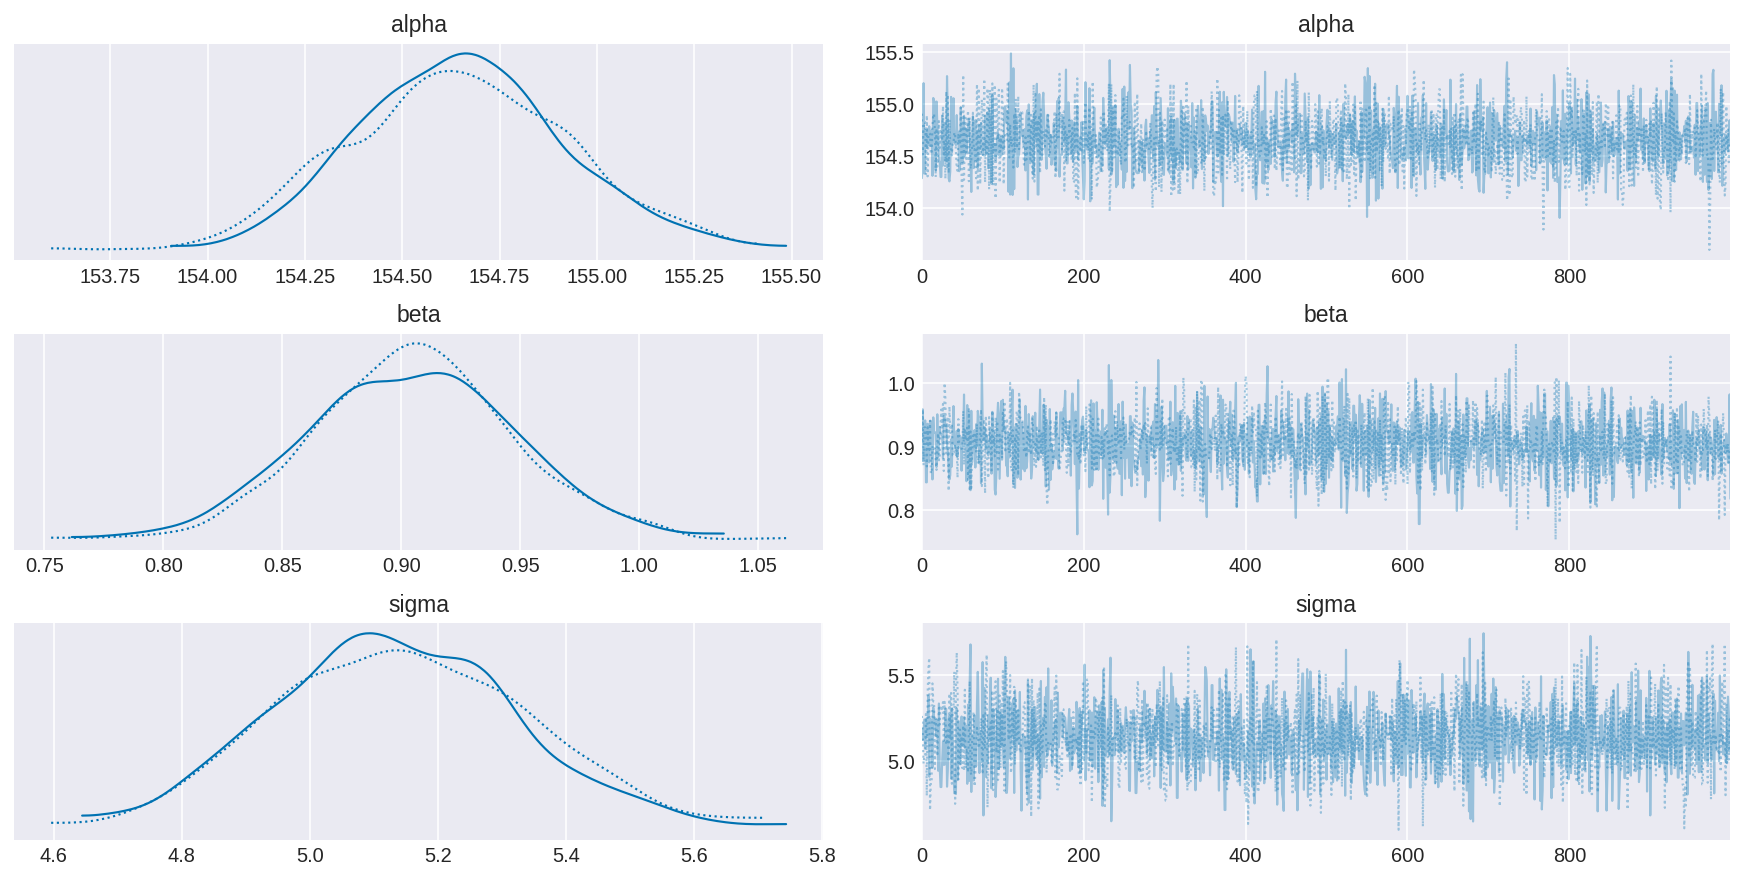

In [35]:
_ = pm.traceplot(trace_4_4_2, var_names=["alpha", "beta", "sigma"])

In [36]:
pm.trace_to_dataframe(trace_4_4_2)[:5]

,alpha,beta,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,mu__10,mu__11,mu__12,mu__13,mu__14,mu__15,mu__16,mu__17,mu__18,mu__19,mu__20,mu__21,mu__22,mu__23,mu__24,mu__25,mu__26,mu__27,mu__28,mu__29,mu__30,mu__31,mu__32,mu__33,mu__34,mu__35,mu__36,...,mu__306,mu__307,mu__308,mu__309,mu__310,mu__311,mu__312,mu__313,mu__314,mu__315,mu__316,mu__317,mu__318,mu__319,mu__320,mu__321,mu__322,mu__323,mu__324,mu__325,mu__326,mu__327,mu__328,mu__329,mu__330,mu__331,mu__332,mu__333,mu__334,mu__335,mu__336,mu__337,mu__338,mu__339,mu__340,mu__341,mu__342,mu__343,mu__344,mu__345
0,154.287095,0.876805,5.184564,156.724670,146.781872,142.730182,161.298357,150.982704,170.023162,148.323006,163.436059,145.365024,162.566064,158.539231,150.932990,146.384160,156.614538,144.470172,157.370952,151.902413,148.422434,157.743807,152.250411,145.911878,148.024722,145.887021,150.137567,163.112918,147.676724,148.546719,155.655819,148.845003,145.986449,156.351815,156.774384,158.116662,158.091805,164.380624,149.093573,158.539231,...,156.252387,155.233250,156.351815,150.609849,158.936943,154.363256,151.827842,151.305845,154.437827,159.732366,157.992377,159.682652,153.244691,145.936735,152.393088,155.804961,151.504701,148.284886,152.756594,161.820354,152.474124,149.665284,152.797265,160.975216,148.497005,152.324982,146.259875,153.567832,148.173864,153.468404,153.393833,156.774384,149.342143,150.783848,150.584992,156.028674,144.818170,160.527790,162.193209,160.850931
1,154.509338,0.958119,5.122272,157.172970,146.308092,141.880654,162.170814,150.898503,171.704744,147.992148,164.506763,144.759847,163.556086,159.155810,150.844178,145.873497,157.052624,143.782008,157.879187,151.903504,148.100797,158.286620,152.283775,145.357415,147.666202,145.330253,149.974988,164.153654,147.285931,148.236608,156.004996,148.562554,145.438902,156.765537,157.227294,158.694053,158.666891,165.538926,148.834176,159.155810,...,156.656888,155.543238,156.765537,150.491070,159.590405,154.592561,151.822017,151.251611,154.674048,160.459596,158.558242,160.405271,153.370263,145.384577,152.439683,156.167969,151.468909,147.950493,152.836900,162.741220,152.528235,149.458906,152.881343,161.817705,148.182283,152.365261,145.737686,153.723371,147.829175,153.614722,153.533236,157.227294,149.105798,150.681205,150.463908,156.412428,144.162278,161.328786,163.148653,161.681894
2,155.201636,0.911344,5.184961,157.735231,147.400772,143.189480,162.489082,151.767081,171.557570,149.002613,164.710991,145.928111,163.806726,159.621270,151.715408,146.987393,157.620760,144.998010,158.406971,152.723018,149.105957,158.794513,153.084724,146.496507,148.692579,146.470670,150.888652,164.375121,148.330873,149.235138,156.624276,149.545172,146.574015,157.347689,157.786903,159.182055,159.156219,165.692764,149.803533,159.621270,...,157.244344,156.185062,157.347689,151.379538,160.034648,155.280797,152.645510,152.102951,155.358305,160.861405,159.052874,160.809732,154.118170,146.522343,153.233021,156.779293,152.309640,148.962992,153.610846,163.031641,153.317250,150.397765,153.653119,162.153212,149.183466,153.162233,146.858213,154.454040,148.847596,154.350695,154.273187,157.786903,150.061895,151.560392,151.353702,157.011819,145.359716,161.688161,163.419183,162.024031
3,154.330072,0.878284,5.240708,156.771758,146.812192,142.753669,161.353158,151.020109,170.092677,148.355925,163.494465,145.392954,162.623003,158.589379,150.970311,146.413810,156.661440,144.496593,157.419130,151.941369,148.455521,157.792613,152.289953,145.940730,148.057138,145.915831,150.173546,163.170779,147.708553,148.580015,155.701105,148.878802,146.015427,156.398274,156.821556,158.166097,158.141198,164.440623,149.127791,158.589379,...,156.298679,155.277823,156.398274,150.646625,158.987761,154.406361,151.866672,151.343795,154.481058,159.784526,158.041603,159.734729,153.285910,145.965629,152.432871,155.850498,151.542986,148.317741,152.796990,161.876035,152.514044,149.700466,152.837730,161.029472,148.530217,152.364650,146.289315,153.609596,148.206532,15

Text(0, 0.5, 'height')

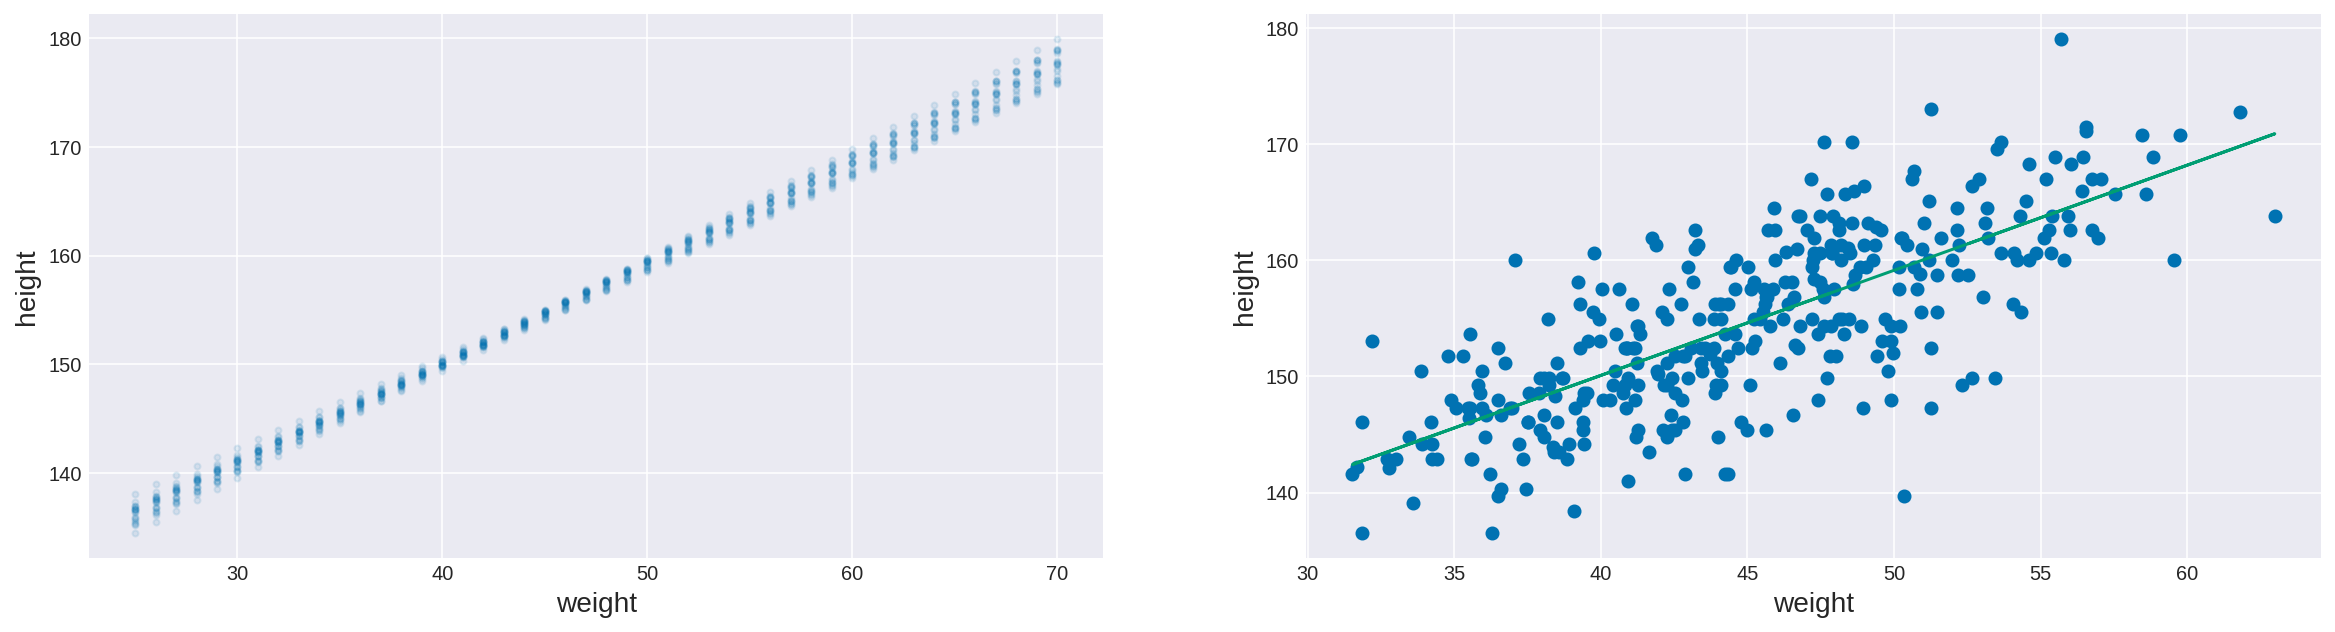

In [37]:
# 4.58
# We are doing manually, what in thebook is done using the link function. 
# In the book on code 4.58 the following operations are performed manually.
weigth_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
chain_N_thinned = trace_4_4_2[::100]
mu_pred = np.zeros((len(weigth_seq), len(chain_N_thinned)*trace_4_4_2.nchains))

for i, w in enumerate(weigth_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * (w - d2.weight.mean())

# plot the sample mu
_, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(weigth_seq, mu_pred, 'C0.', alpha=0.1)
ax[0].set_xlabel('weight', fontsize=14)
ax[0].set_ylabel('height', fontsize=14)

# plot raw data and mean 
ax[1].plot(d2.weight, d2.height, 'o')
ax[1].plot(d2.weight, trace_4_4_2['alpha'].mean() + trace_4_4_2['beta'].mean() * d2.weight_c)
ax[1].set_xlabel('weight', fontsize=14)
ax[1].set_ylabel('height', fontsize=14)

In [38]:
# Now we are going to use sample_ppc() from PyCM3. 
# This function give us posterior predictive samples, that is for each value of the input variable we get the a sample (from the posterior) of the output variable. 
# Thus in the following example the shape of height_pred['height_hat'].shape is (200, 352)
predictive_4_4_2 = pm.sample_ppc(trace_4_4_2, 200, m_4_4_2)
mu_pred_4_4_2 = trace_4_4_2['mu']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 527.07it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


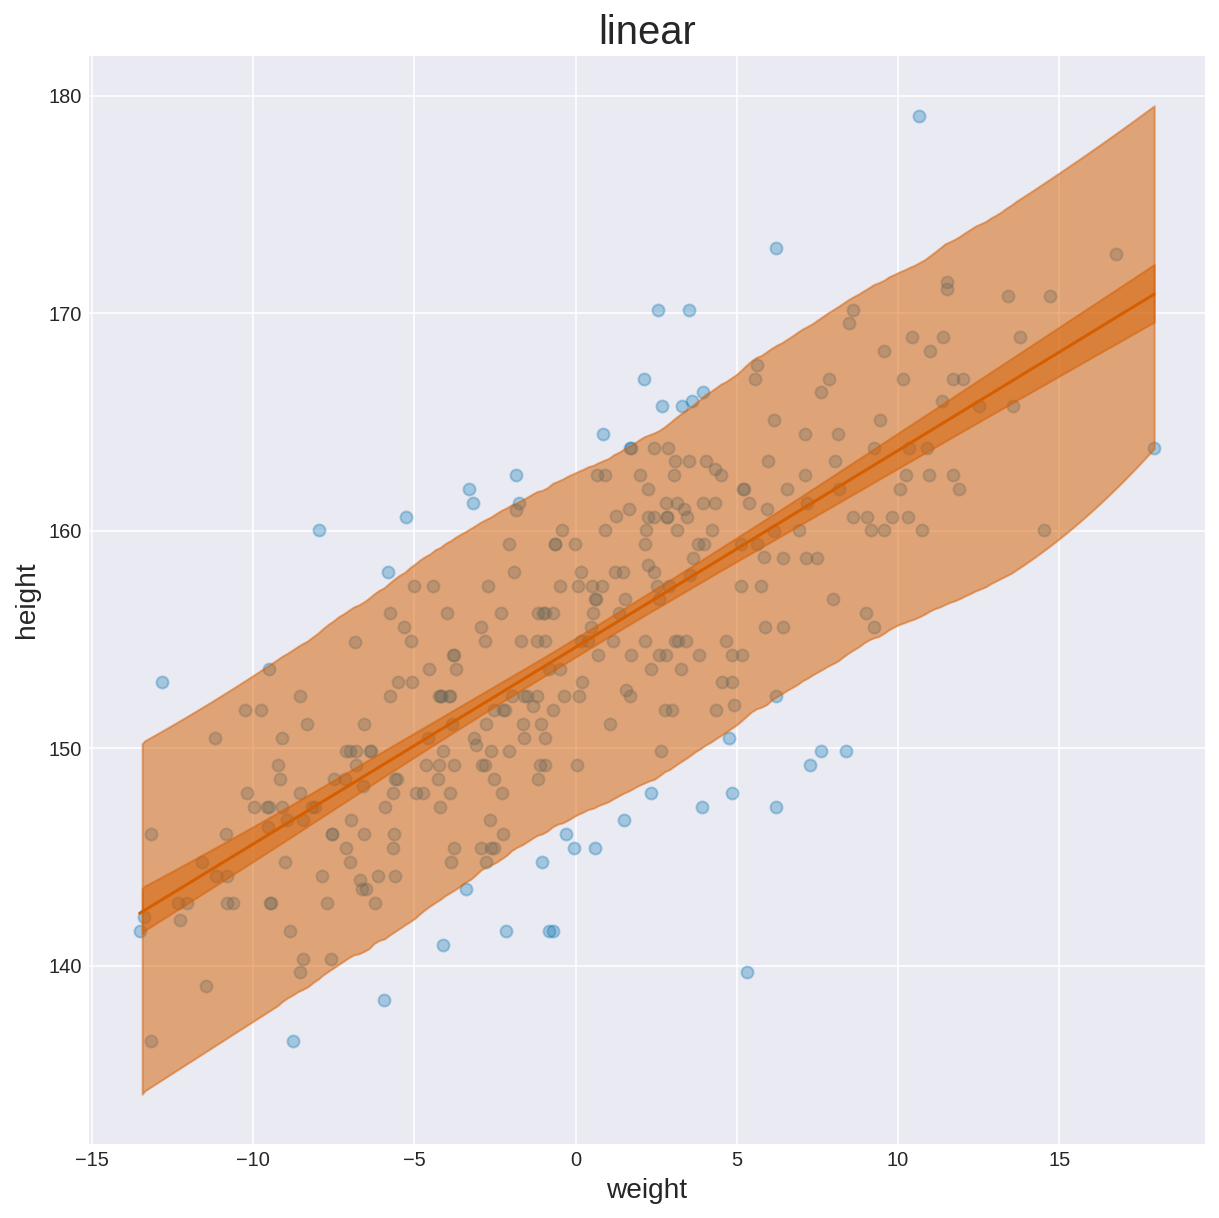

In [39]:
# The solid line is the average line for mean height
# The narrow shadow is the distribution of 89% interval of mu
# The wider shaded region is the 89% interval of the actual height at each weight
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot(d2.weight_c, d2.height, mu_pred_4_4_2, predictive_4_4_2['height'], 0.89, ax, 'linear', 'weight', 'height')

## Curve From Lines
- Polynominal Regression $\mu_i = \alpha + \beta_1x_i + \beta_2x_i^2$
- B-Splines

In [40]:
url = 'https://raw.githubusercontent.com/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/main/Howell1.csv'
d = pd.read_csv(url, sep=';')
d = d.assign(weight_s=pd.Series((d.weight - d.weight.mean())/d.weight.std()))
d.head()

,height,weight,age,male,weight_s
0,151.765,47.825606,63.0,1,0.829869
1,139.700,36.485807,63.0,0,0.059459
2,136.525,31.864838,65.0,0,-0.254483
3,156.845,53.041915,41.0,1,1.184257
4,145.415,41.276872,51.0,0,0.384957


In [41]:
with pm.Model() as model_linear:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta1 = pm.Lognormal('beta1', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta1 * d.weight_s)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_linear = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta1, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1109.22it/s]


In [42]:
with pm.Model() as model_quadratic:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta1 = pm.Lognormal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta1 * d.weight_s + beta2 * d.weight_s**2)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_quadratic = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta2, beta1, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 782.74it/s]


In [43]:
with pm.Model() as model_cubic:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta1 = pm.Lognormal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    beta3 = pm.Normal('beta3', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta1 * d.weight_s + beta2 * d.weight_s**2 + beta3 * d.weight_s**3)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_cubic = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta3, beta2, beta1, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:04<00:00, 415.55it/s]


In [44]:
# calculate the mu hpd
mu_pred_linear = trace_linear['mu']
mu_pred_quadratic = trace_quadratic['mu']
mu_pred_cubic = trace_cubic['mu']

# generate sample predictive for height and caculate hpd
predictive_linear = pm.sample_posterior_predictive(trace_linear, 200, model_linear)
predictive_quadratic = pm.sample_posterior_predictive(trace_quadratic, 200, model_quadratic)
predictive_cubic = pm.sample_posterior_predictive(trace_cubic, 200, model_cubic)

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 577.29it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/a

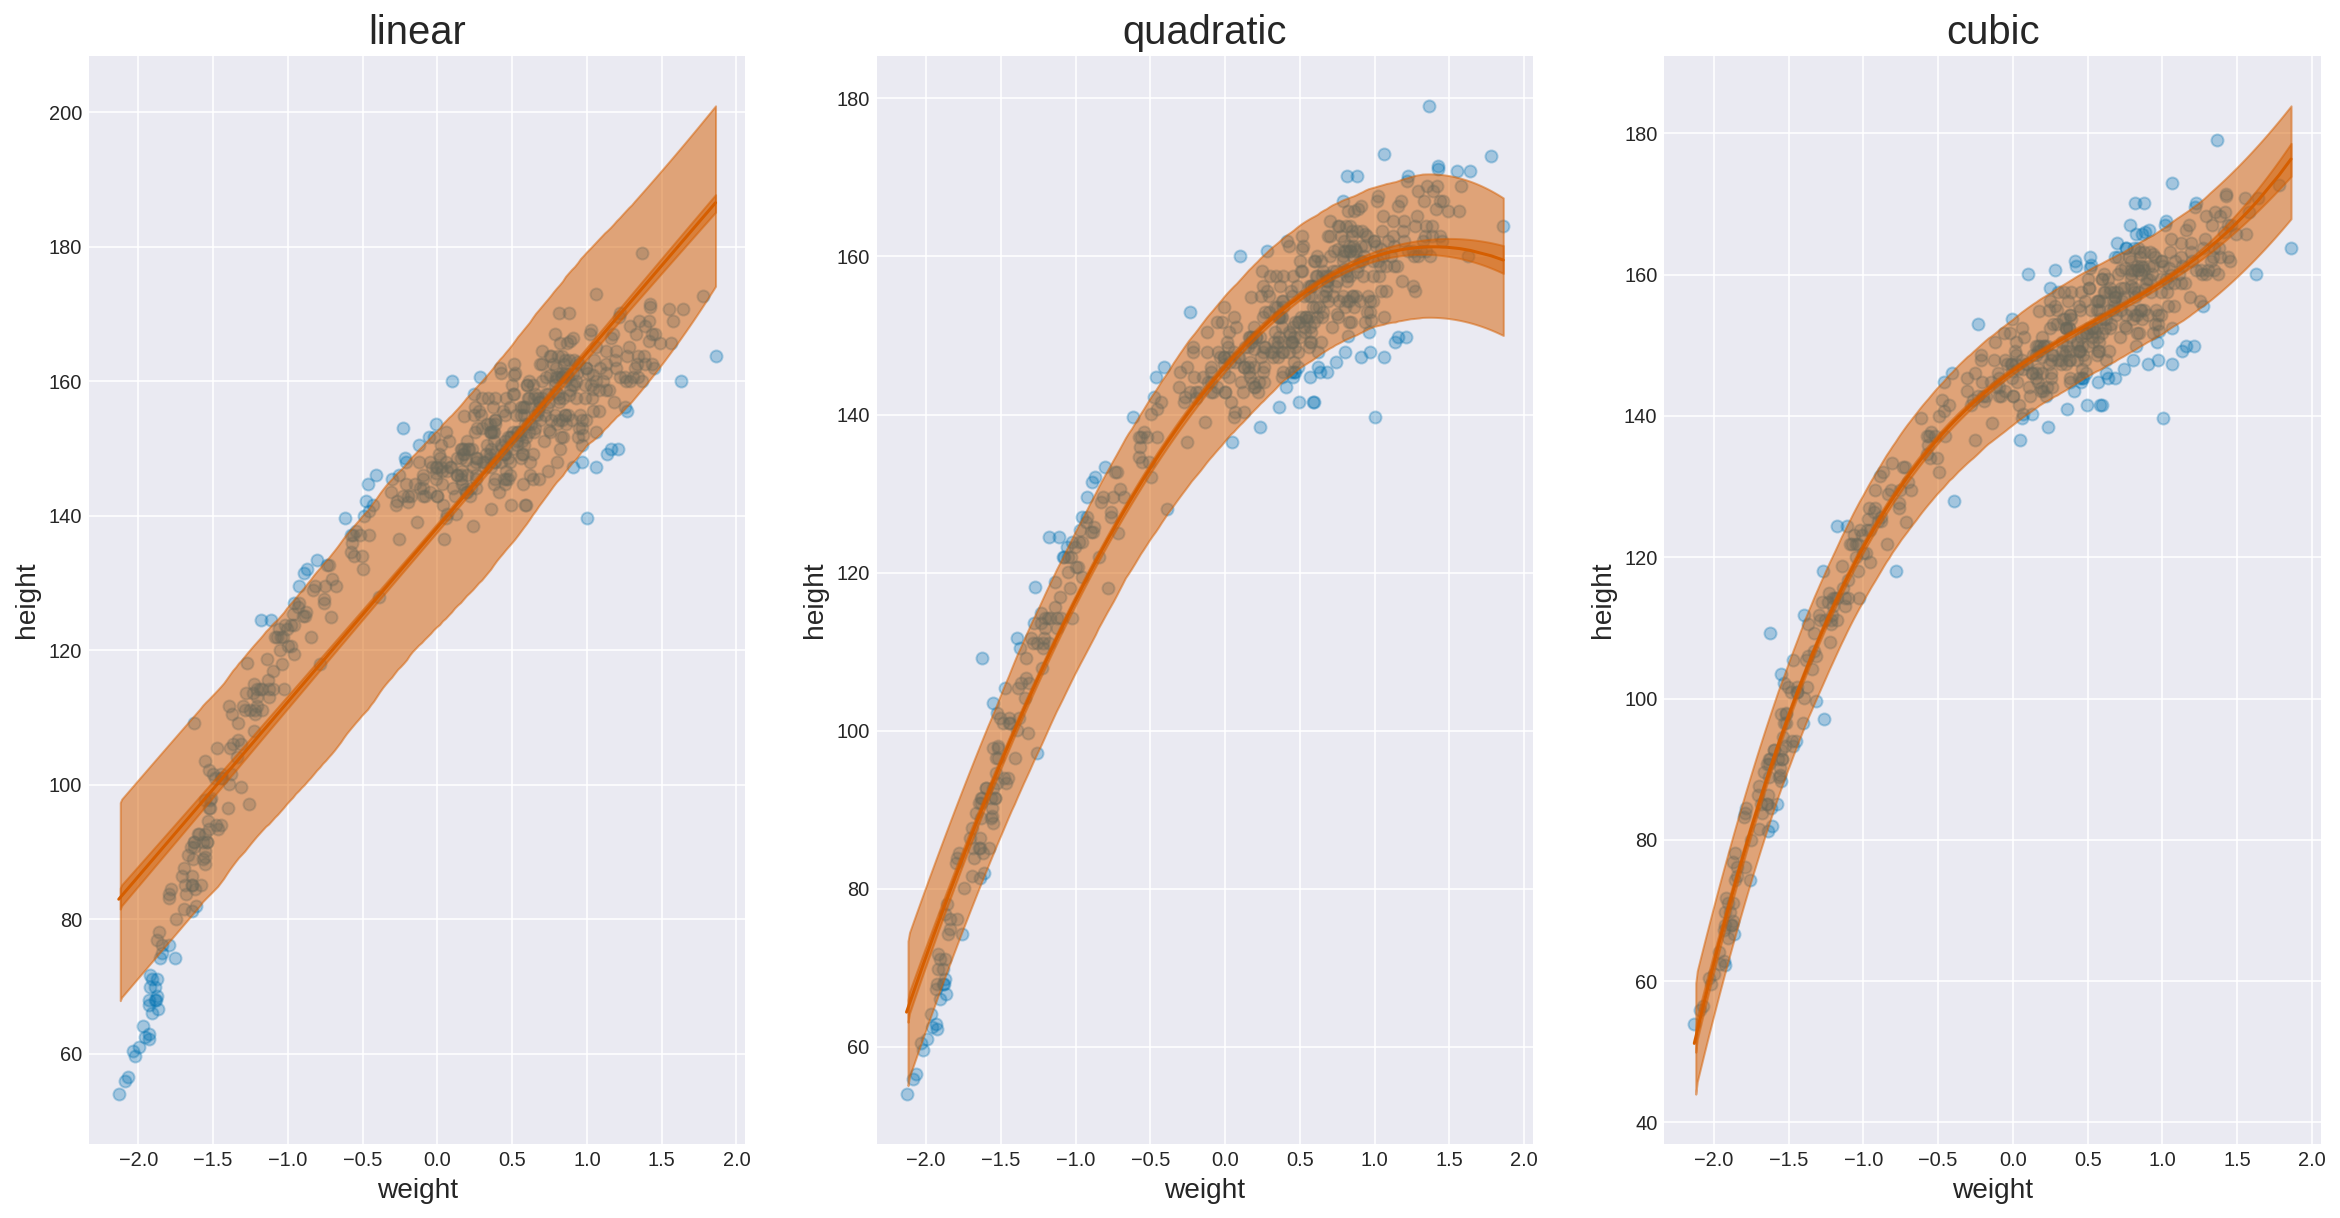

In [45]:
_, ax = plt.subplots(1, 3, figsize=(20, 10))
plot(d.weight_s, d.height, mu_pred_linear, predictive_linear['height'], 0.89, ax[0], 'linear', 'weight', 'height')
plot(d.weight_s, d.height, mu_pred_quadratic, predictive_quadratic['height'], 0.89, ax[1], 'quadratic', 'weight', 'height')
plot(d.weight_s, d.height, mu_pred_cubic, predictive_cubic['height'], 0.89, ax[2], 'cubic', 'weight', 'height')

In [46]:
# A simplified version of model definition
weight_m = np.vstack((d.weight_s, d.weight_s**2, d.weight_s**3))
with pm.Model() as model_cubic_s:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + pm.math.dot(beta, weight_m))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_cubic_s = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 565.82it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


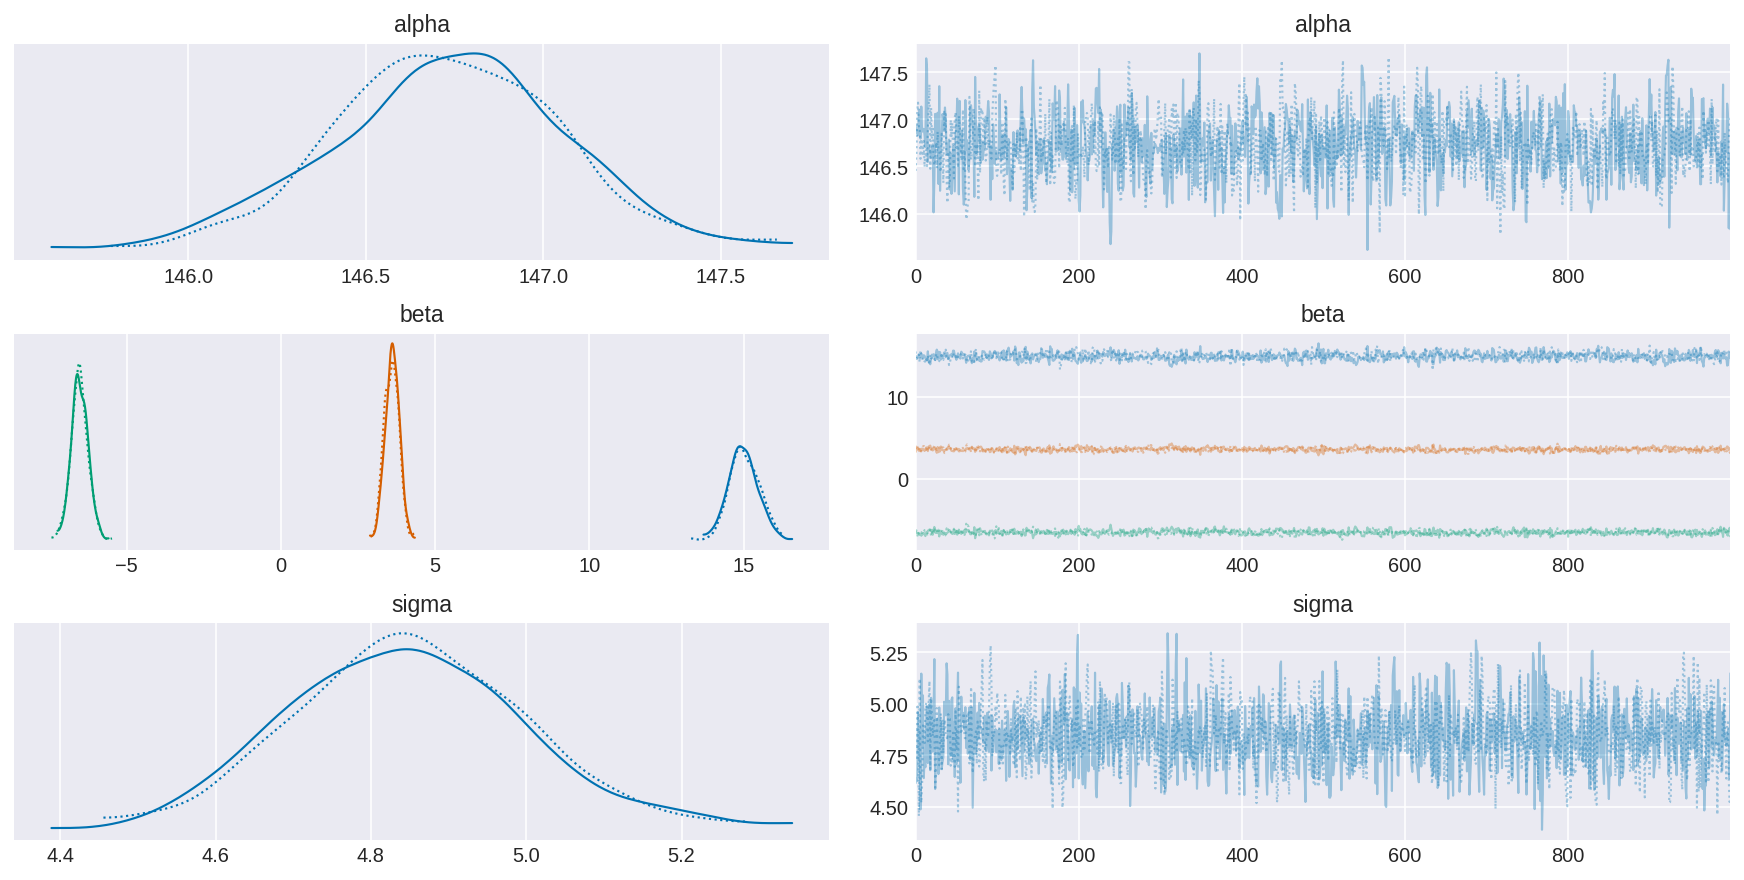

In [47]:
pm.traceplot(trace_cubic_s, ['alpha', 'beta', 'sigma']);

# Practice
- 4E1: $y_i$
- 4E2: 2
- 4E3: 
- 4E4: $\mu_i = \alpha + \beta x_i$
- 4E5: 3


In [48]:
# 4H1
with pm.Model() as model_h_4_1:
    alpha = pm.Normal('alpha', mu=100, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta*d2.weight)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_h_4_1 = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 11000/11000 [00:32<00:00, 340.17it/s]
The acceptance probability does not match the target. It is 0.8942469347493043, but should be close to 0.8. Try to increase the number of tuning steps.


In [49]:
weight_inputs = [46.95, 43.72, 64.78, 32.59, 54.63]
height_mean = []
height_hpd = []
for i, w in enumerate(weight_inputs):
  y_pred = trace_h_4_1['alpha'] + trace_h_4_1['beta'] * w
  height_mean.append(np.mean(y_pred))
  height_hpd.append(az.hdi(y_pred, .89))

print(height_mean)
print(height_hpd)

[156.369717073976, 153.44092904033917, 172.53698971785974, 143.34885138882905, 163.33352267717436]
[array([155.89043876, 156.8227506 ]), array([152.96143641, 153.87031511]), array([171.06117384, 173.94584676]), array([142.37703029, 144.31793337]), array([162.51606921, 164.12394704])]


In [50]:
# 4H2
d3 = d[d.age < 18]
print(len(d3))

with pm.Model() as model_h_4_2:
    alpha = pm.Normal('alpha', mu=100, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta*d3.weight)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d3.height)
    trace_h_4_2 = pm.sample(10000, tune=1000)

    
with model_h_4_2:
  summary = pm.summary(trace_h_4_2, var_names=['alpha', 'beta', 'sigma'])
  parameters = pm.find_MAP()

beta_map = parameters['beta']
print(f'MAP of beta is {beta_map}')
summary

192


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 11000/11000 [00:14<00:00, 780.90it/s]
logp = -694.75, ||grad|| = 10.271: 100%|██████████| 27/27 [00:00<00:00, 1403.84it/s]  

MAP of beta is 2.719600076548023


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,58.214,1.442,55.558,60.963,0.017,0.012,7530.0,7522.0,7553.0,8987.0,1.0
beta,2.721,0.070,2.587,2.849,0.001,0.001,7489.0,7489.0,7518.0,8829.0,1.0
sigma,8.530,0.446,7.696,9.368,0.004,0.003,10993.0,10987.0,10973.0,9989.0,1.0


/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 591.22it/s]
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


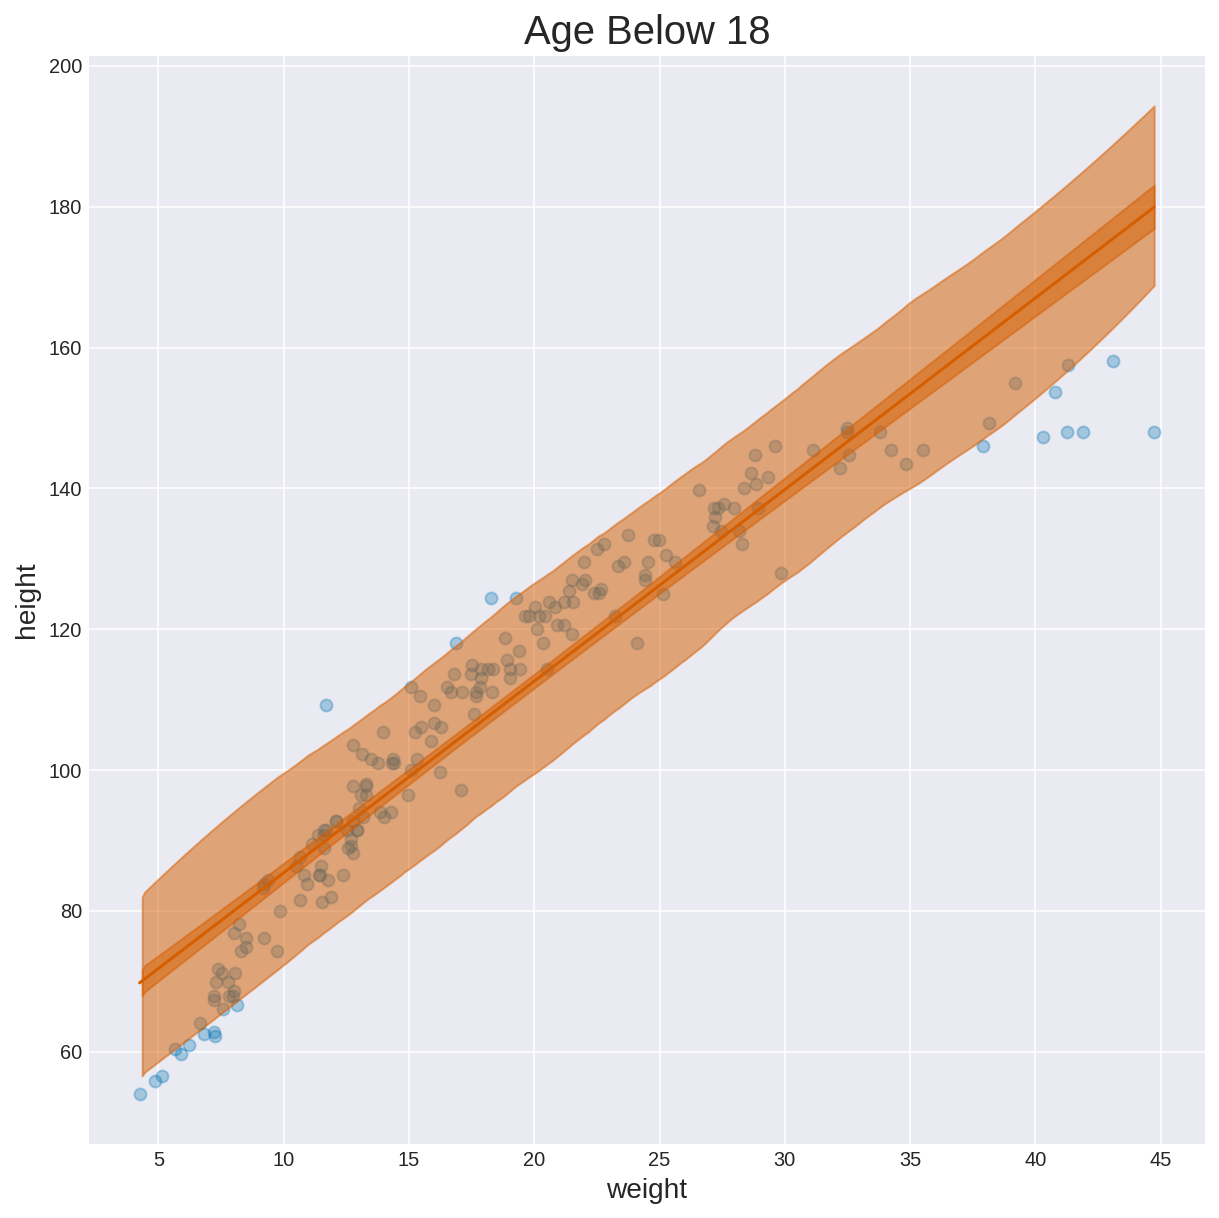

In [51]:
predictive_h_4_2 = pm.sample_posterior_predictive(trace_h_4_2, 200, model_h_4_2)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot(d3.weight, d3.height, trace_h_4_2['mu'], predictive_h_4_2['height'], 0.89, ax, 'Age Below 18', 'weight', 'height')

In [25]:
# 4H3
with pm.Model() as model_h_4_3:
    alpha = pm.Normal('alpha', mu=138, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta*np.log(d.weight))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_h_4_3 = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 11000/11000 [00:30<00:00, 357.11it/s]


In [26]:
with model_h_4_3:
  summary = pm.summary(trace_h_4_3, var_names=['alpha', 'beta', 'sigma'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-23.781,1.339,-26.349,-21.306,0.017,0.012,6299.0,6221.0,6340.0,6257.0,1.0
beta,47.075,0.384,46.349,47.796,0.005,0.003,6273.0,6261.0,6305.0,6191.0,1.0
sigma,5.156,0.158,4.851,5.445,0.002,0.001,7738.0,7710.0,7812.0,8590.0,1.0


/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 628.27it/s]
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


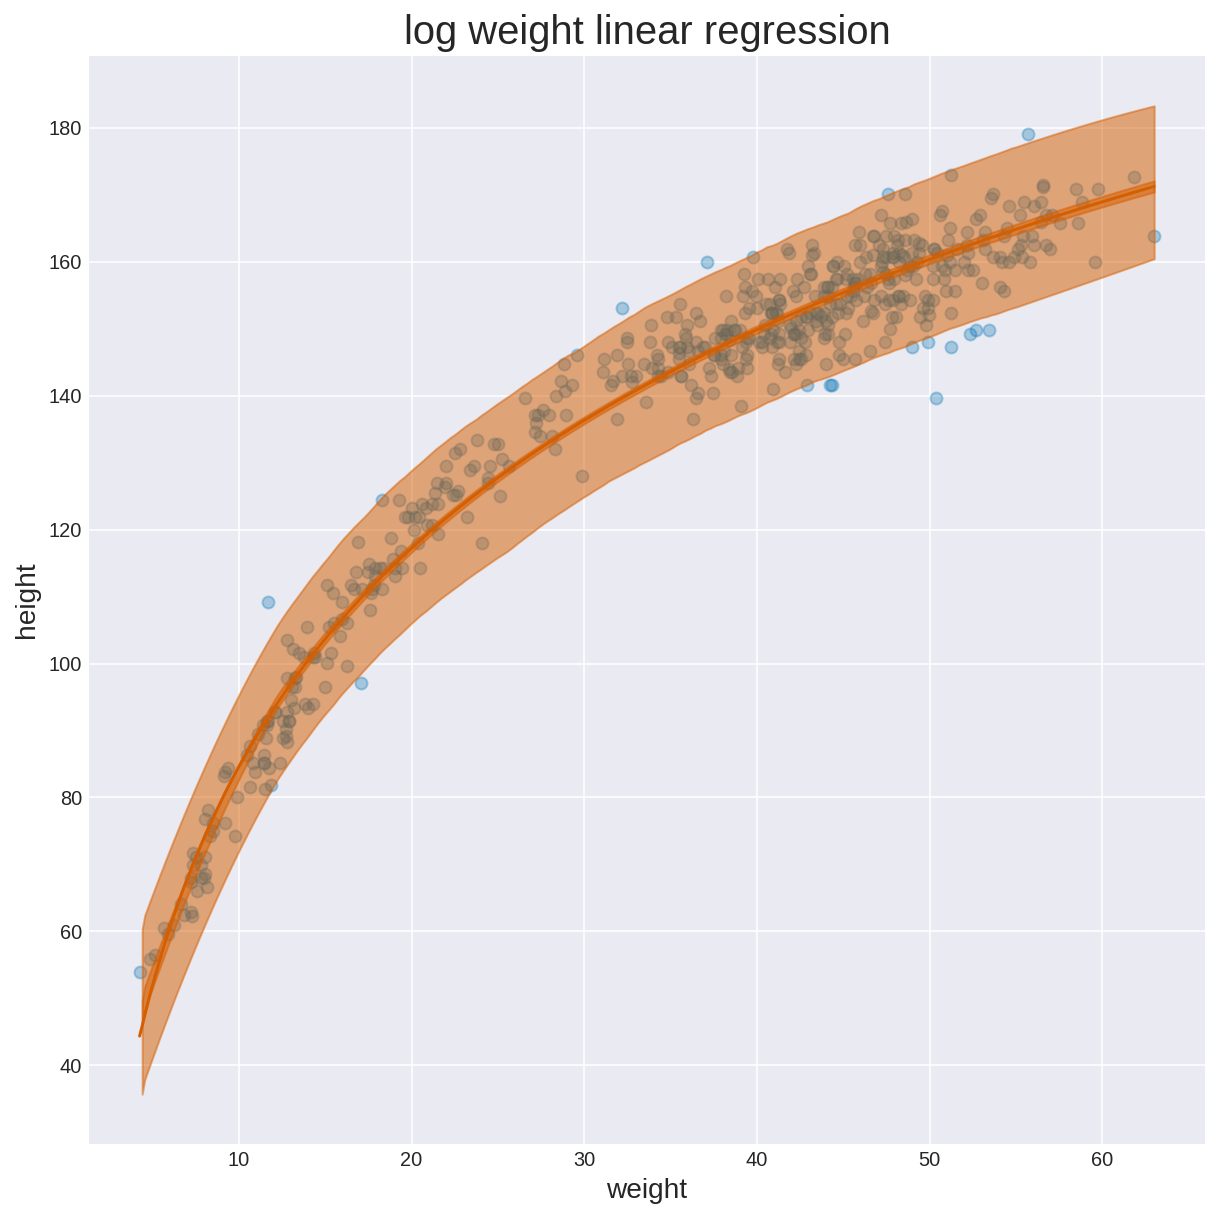

In [27]:
predictive_h_4_3 = pm.sample_posterior_predictive(trace_h_4_3, 200, model_h_4_3)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot(d.weight, d.height, trace_h_4_3['mu'], predictive_h_4_3['height'], 0.98, ax, 'log weight linear regression', 'weight', 'height')